## Question
1. Model performance can refer to the [Classification Report](#Classification-Report) and [Confusion matrices](#Confusion-Matrix). The model have around 99% accuracy on tagging '美國大選' and '足球' and 98% accuracy on tagging '梁振英'.
2. The model are tuned based on the provided label data. I split the data into 70/30 for training set and test set. And using cross validation + grid search to find the best parameters that can generate a model achrived best score. And the model will check with the test set to see whether the performance persist in order to check whether we have a overfitting model. There are some parameters and options needed to adjust during model tunning:
  1. Feature extraction methods. I plan to extract features from text using the vectorization technique. Most common way are CountVectorizer and TFIDFVectorizer and selected the method based on the score.
  2. Numbers of features. After vectorized the text, there are over 60k features and we know that not all the features are useful and could decrease the model accuracy. By adjusting the `max_features` parameters we could check the performace of the model when we are reducing the # of features. The optimal size is `10000` based of the given data.
  3.Kernel. This is the core part of SVM. Beside testing with the default `rbf` kernel. `linear` kenrnel are also listed in the grid search params. As the # of features is large and relative small # of traning sample. `linear` or `logistic regression` could perform pretty well and the time for training with `linear` kernel is much faster.
  4. Using grid search for hyperparmater selection with cross validation. Using 3 as the fold. Every set of parameters will have 3 set of different training and validation set data which size are 7 to 3. By that we can get a much fair score given we have limited numbers of training samples.
3. The model is created base on the text data. In the training phase, we vectorize the text in training data to get the features. Custom tokenizer is used for building the features map. The tokenizer is working in this way: First, clean the text by removing the HTML markup. Convert it to simpified Chinese and tokenzied it (trad to simp is because the tokenizer I am using have a much better performance in simp Chinese). Filter out all useless tokens which are punctuations, empty token, and word with length smaller than 2 (In Chinese words single characters generally have much lower importance).  
For the label, we encode the Chinese label using LabelEncoder so we can get the label as integer which can be used for SVC. After the feature extraction then will go to the training phase which many things are described in Q2, and we got the best SVM model.
The linear SVM model basically is to learn the decision boundary that seperate different classes of training data with the largest distance or margins.
In the prediction phase, we use the vectorizer fitted with the training data previously to build features for the text. Use that as a input to the model and the model will provide the class label as a output. Similarily we use the fitted LabelEncoder to retrieve back the original Chinese Label.

In [1]:
import pandas as pd

In [2]:
# For text clean up and tokenization
from bs4 import BeautifulSoup
from hanziconv import HanziConv
import jieba
import re

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.font_manager as mfm

## Data Exploration  
See how's the labeled data looks like

In [4]:
df = pd.read_csv('offsite-test-material/offsite-tagging-training-set (1).csv')
df.head(10)

,id,tags,text
0,3443,足球,利物浦重賽擊敗乙組仔 英足盃過關 英格蘭足總盃第三圈今晨重賽，貴為英超勁旅的利物浦上場被乙組...
1,76056,足球,【中超】恒大「暴力戰」絕殺國安 楊智反重力插水惹爭議（有片） 中超首輪賽事重頭戲，廣州恒大主...
2,93405,足球,【歐霸決賽】阿積士控球率起腳佔優 隊長卡拉臣輸波不服氣 阿積士以歐洲主要決賽最年輕、平均22...
3,26767,足球,【歐國盃】韋莫斯澄清更衣室未內訌 盼以團結力量挫愛爾蘭 今晚3場直播\r\r\nE組｜比利時...
4,20843,梁振英,王維基參選 點解？ 王維基在宣布有意出選的記者會上，打出ABC，Anyone But CY的...
5,74481,足球,【港超】大埔5：1炒飛馬 近7仗第5勝 與前四只差兩分 港超周日早場便出現大比數戰果，主場出...
6,52914,美國大選,回看內政兩大建樹 奧巴馬醫保前景難料 亮麗經濟數字埋隱憂 在任近8年，美國總統奧巴馬在內政上...
7,94059,足球,【牛丸退任圖輯】一年半狂破紀錄 由銅紫荊星章到亞洲最佳女教練 從來，女教練執教男子職業足球隊...
8,41325,足球,【足球】拉爾拉拿絕殺 艾拿戴斯︰英格蘭首捷因幸運硬幣 英格蘭主帥艾拿戴斯首戰取得好開始，憑拉...
9,5203,美國大選,"美國民主共和兩黨初選早期重要日子 二月三月 <p><span style=""font-siz..."


### Check tags 
See the distribution amount the traning set

In [5]:
stat_df = pd.DataFrame({'count' : df.groupby( [ "tags"] ).size()}).reset_index()
stat_df['percentages'] = stat_df['count'] / stat_df['count'].sum() * 100
stat_df

,tags,count,percentages
0,梁振英,929,23.857216
1,美國大選,842,21.623010
2,足球,2123,54.519774


## Split data for train and test
70% data for training  
30% data for testing

In [6]:
train_df, test_df = train_test_split(df, test_size=0.3)

In [7]:
stat_train_df = pd.DataFrame({'count' : train_df.groupby( [ "tags"] ).size()}).reset_index()
stat_train_df['percentages'] = stat_train_df['count'] / stat_train_df['count'].sum() * 100
stat_train_df

,tags,count,percentages
0,梁振英,640,23.486239
1,美國大選,595,21.834862
2,足球,1490,54.678899


In [8]:
stat_test_df = pd.DataFrame({'count' : test_df.groupby( [ "tags"] ).size()}).reset_index()
stat_test_df['percentages'] = stat_test_df['count'] / stat_test_df['count'].sum() * 100
stat_test_df

,tags,count,percentages
0,梁振英,289,24.721985
1,美國大選,247,21.129170
2,足球,633,54.148845


Training set and test set have similiar distribution of tags

## Feature engineering
Tokenize `text` into features using CountVectorizer. To do this, Jieba tokenizer is used for Chinese tokenization.
Steps:
1. First remove all HTML markup 
2. Convert trad to simp
3. Remove all punctuations and empty token

In [9]:
def text_tokenizer(text):
    soup = BeautifulSoup(text) #Remove HTML
    return list(filter(lambda y: len(y) > 1,
            map(lambda x: re.sub("[！，。～《》：（）【】「」？”“；：、'\s]","",x), # Remove punctuations
                jieba.cut(HanziConv.toSimplified(soup.get_text())))))

In [46]:
count_vectorizer = CountVectorizer(tokenizer=text_tokenizer, max_features=10000)

Fit vectorizer and transform to feature

In [47]:
X= count_vectorizer.fit_transform(train_df['text'])

In [48]:
X.shape

(2725, 10000)

Convert Lable to encoding

In [49]:
tags_enc = preprocessing.LabelEncoder()
tags_enc.fit(train_df['tags'])
y = tags_enc.transform(train_df['tags'])

## Create classification model - SVM
Trying SVM for this classification problem. Tune hyperparmaeters using grid search with cross validation

In [50]:
params = [{'kernel': ['rbf'],
           'gamma': [1e-3, 1e-4, 1e-5],
           'C': [1, 10, 100]
          },
          {
            'kernel': ['linear'],
            'C': [0.01, 0.1, 1, 10, 100]
          }]

In [51]:
clf = GridSearchCV(SVC(), params, cv=3)
clf.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'gamma': [0.001, 0.0001, 1e-05], 'C': [1, 10, 100], 'kernel': ['rbf']}, {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
clf.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [53]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.985 (+/-0.008) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.967 (+/-0.010) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.741 (+/-0.017) for {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}
0.988 (+/-0.008) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.985 (+/-0.007) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.968 (+/-0.008) for {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}
0.989 (+/-0.009) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.988 (+/-0.004) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.985 (+/-0.008) for {'kernel': 'rbf', 'C': 100, 'gamma': 1e-05}
0.986 (+/-0.003) for {'C': 0.01, 'kernel': 'linear'}
0.990 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
0.990 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
0.990 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
0.990 (+/-0.005) for {'C': 100, 'kernel': 'linear'}


## Classification Report
Check performance with test set

In [59]:
test_df.reset_index()
y_test = tags_enc.transform(test_df['tags'])
X_test = count_vectorizer.transform(test_df['text'])
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9861    0.9792    0.9826       289
           1     0.9919    0.9879    0.9899       247
           2     0.9890    0.9937    0.9913       633

   micro avg     0.9889    0.9889    0.9889      1169
   macro avg     0.9890    0.9869    0.9879      1169
weighted avg     0.9889    0.9889    0.9889      1169



## Confusion Matrix

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[283   1   5]
 [  1 244   2]
 [  3   1 629]]


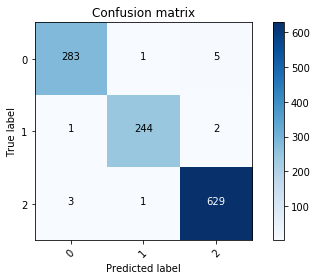

In [82]:
%matplotlib inline

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2'], title='Confusion matrix')

Normalized confusion matrix
[[0.97923875 0.00346021 0.01730104]
 [0.00404858 0.98785425 0.00809717]
 [0.00473934 0.00157978 0.99368088]]


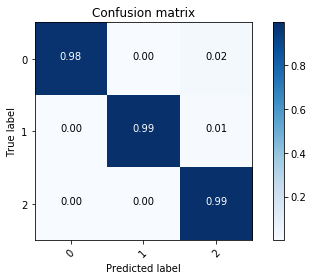

In [84]:
%matplotlib inline
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2'], title='Confusion matrix', normalize=True)

## Generate predictions on final test set

In [85]:
final_test_df = pd.read_csv('offsite-test-material/offsite-tagging-test-set (1).csv')

In [86]:
ft_X = count_vectorizer.transform(final_test_df.text)
pred_y = clf.predict(ft_X)

In [87]:
final_test_df['predicted_tag']=pd.Series(tags_enc.inverse_transform(pred_y), index=final_test_df.index)

In [90]:
final_test_df.head(10)

,id,text,predicted_tag
0,6,南華添鋒力 簽前厄瓜多爾國腳保耶 港超勁旅南華宣布羅致前厄瓜多爾國腳菲力斯保耶（Felix ...,足球
1,128,如果大學$0捐款 科大嶺南將蝕過千萬元 據now新聞台報道，身兼8大校監的特首梁振英曾以大學...,梁振英
2,136,英超最強火力對碰 雙城爭冠靠鋒霸 英超今季風起雲湧，傳統「Big 5」只剩兩隊名列積分榜前5...,足球
3,213,【01球評】膺半程冠軍 阿仙奴今季不奪標更待何時？ 近年「兵工廠」每季的起落都離不開一個循環...,足球
4,658,【書商失蹤】梁振英：希望失蹤的李波本人提供資料 行政長官梁振英出席行政會議前見記者，被問及李...,梁振英
5,700,【施政盤點】三份施政報告 僅一半政策達標 行政長官梁振英即將公布任內第四份施政報告，《香港0...,梁振英
6,729,【施政盤點】「治港絕招」 設19委員會 空談多實務少 行政長官梁振英上任3年多，先後成立多個...,梁振英
7,837,高普首簽 「新馬迪」來季投紅軍 利物浦傷兵滿營及戰績不穩，主帥高普仍不忘投資未來，昨以510...,足球
8,1037,「最潮主帥」鬥利物浦：我已領先1：0 英乙球隊埃克塞特在明晨的足總盃於主場迎戰利物浦，雖然越...,足球
9,1095,紅軍超殘陣逼和英乙隊 高普：負擔不起重賽 逾十名球員受傷的利物浦，今晨在足總盃第三圈以大部份...,足球


In [89]:
final_test_df.to_csv('prediction.csv')